# Training of the models
<img src="https://www.nuscenes.org/public/tutorials/trajectory.gif" width="300" align="left">

After visualizing and understanding our data, it's time to train diferent models to complete the task of imitation learning

First we import libraries and set up environment

In [8]:
import sys
import os
from pathlib import Path

current_path = Path(os.getcwd())

project_root = current_path.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Working in: {current_path}")
print(f"Root of the project: {project_root}")

try:
    import nuimages 
    import nuscenes
except ImportError as e:
    print(f"Error: {e}")

📍 Trabajando en: /root/nuscenes-devkit/python-sdk/tutorials
🚀 Añadida raíz del proyecto: /root/nuscenes-devkit/python-sdk
✅ ¡ÉXITO TOTAL! NuImages y Nuscenes importado.


In [ ]:
import argparse
import pickle
from nuscenes import NuScenes
import os
import json
from nuscenes.map_expansion.map_api import NuScenesMap

from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import transform_matrix
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
import torch
import numpy as np
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle
from nuscenes.eval.prediction.data_classes import Prediction

from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.metrics import MinADEK, MinFDEK, RowMean
from nuscenes.prediction.models.backbone import ResNetBackbone

from matplotlib import pyplot as plt

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle

from nuscenes.map_expansion import arcline_path_utils
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet

from torch.utils.data import Dataset, DataLoader
from nuscenes.prediction.models.mtp import MTPLoss

In [10]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/root/nuscenes-devkit/data/sets/nuscenes'

nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.247 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


### Data Splits for the nuScenes Prediction Challenge

nuScenes provides predefined splits for training, validation, and testing.  
Each sample in the prediction challenge is represented as a pair of identifiers:

- an **instance_token** (which identifies the agent),  
- a **sample_token** (which identifies the frame in the scene).

The function `get_prediction_challenge_split` returns a list of  
`{instance_token}_{sample_token}` strings.  
Each of these entries corresponds to one prediction task:  
predict the future trajectory of that specific agent at that specific timestamp.

We use these splits to build our dataset for training and validation.

In [37]:
mini_train = get_prediction_challenge_split("mini_train", dataroot=DATAROOT)
mini_train[:5]

['bc38961ca0ac4b14ab90e547ba79fbb6_39586f9d59004284a7114a68825e8eec',
 'bc38961ca0ac4b14ab90e547ba79fbb6_356d81f38dd9473ba590f39e266f54e5',
 'bc38961ca0ac4b14ab90e547ba79fbb6_e0845f5322254dafadbbed75aaa07969',
 'bc38961ca0ac4b14ab90e547ba79fbb6_c923fe08b2ff4e27975d2bf30934383b',
 'bc38961ca0ac4b14ab90e547ba79fbb6_f1e3d9d08f044c439ce86a2d6fcca57b']

In [38]:
len(mini_train)

742

### How to get past and future data for an agent

The class `PredictHelper` provides methods for querying past and future data for an agent. This class is instantiated by wrapping an instance of the `NuScenes` class. 

In [39]:
helper = PredictHelper(nuscenes)

To get the data for an agent at a particular point in time, use the `get_sample_annotation` method.

In [40]:
instance_token, sample_token = mini_train[0].split("_")
annotation = helper.get_sample_annotation(instance_token, sample_token)
annotation

{'token': 'a286c9633fa34da5b978758f348996b0',
 'sample_token': '39586f9d59004284a7114a68825e8eec',
 'instance_token': 'bc38961ca0ac4b14ab90e547ba79fbb6',
 'visibility_token': '4',
 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
 'translation': [392.945, 1148.426, 0.766],
 'size': [1.708, 4.01, 1.631],
 'rotation': [-0.5443682117180475, 0.0, 0.0, 0.8388463804957943],
 'prev': '16140fbf143d4e26a4a7613cbd3aa0e8',
 'next': 'b41e15b89fd44709b439de95dd723617',
 'num_lidar_pts': 0,
 'num_radar_pts': 0,
 'category_name': 'vehicle.car'}

This dictionary represents the annotation of a single agent at a specific moment in time. Each annotation corresponds to one bounding box describing an object in one frame. 

Meaning of the Annotation Fields

- **token** — Unique ID of this annotation record.  
- **sample_token** — The frame (timestamp) where the object appears.  
- **instance_token** — Unique ID of the object across the whole scene (tracks the same agent over time).  
- **visibility_token** — Visibility level (1 = low visibility, 4 = fully visible).  
- **attribute_tokens** — Extra properties (e.g., *vehicle.moving*, *pedestrian.standing*).  
- **translation** — (x, y, z) position of the object in the global map.  
- **size** — Width, length, and height of the 3D bounding box.  
- **rotation** — Orientation of the object encoded as a quaternion.  
- **prev / next** — Links to the same object in the previous and next frames (used to build trajectories).  
- **num_lidar_pts / num_radar_pts** — Number of lidar or radar points hitting this object.  
- **category_name** — Semantic class of the object (e.g., `"vehicle.car"`).


To get the future/past of an agent, use the `get_past_for_agent`/`get_future_for_agent` methods. If the `in_agent_frame` parameter is set to true, the coordinates will be in the agent's local coordinate frame. Otherwise, they will be in the global frame.

In [41]:
future_xy_local = helper.get_future_for_agent(instance_token, sample_token, seconds=3, in_agent_frame=True)
future_xy_local

array([[ 0.01075063,  0.2434942 ],
       [-0.20463666,  1.20515386],
       [-0.20398583,  2.57851309],
       [-0.25867757,  4.50313379],
       [-0.31359088,  6.67620961],
       [-0.31404147,  9.67727022]])

The agent's coordinate frame is centered on the agent's current location and the agent's heading is aligned with the positive y axis. For example, the last coordinate in `future_xy_local` corresponds to a location 0.31 meters to the left and 9.67 meters in front of the agents starting location.

In [42]:
future_xy_global = helper.get_future_for_agent(instance_token, sample_token, seconds=3, in_agent_frame=False)
future_xy_global

array([[ 392.836, 1148.208],
       [ 392.641, 1147.242],
       [ 392.081, 1145.988],
       [ 391.347, 1144.208],
       [ 390.512, 1142.201],
       [ 389.29 , 1139.46 ]])

Note that you can also return the entire annotation record by passing `just_xy=False`. However in this case, `in_agent_frame` is not taken into account.

In [43]:
helper.get_future_for_agent(instance_token, sample_token, seconds=3, in_agent_frame=True, just_xy=False)

[{'token': 'b41e15b89fd44709b439de95dd723617',
  'sample_token': '356d81f38dd9473ba590f39e266f54e5',
  'instance_token': 'bc38961ca0ac4b14ab90e547ba79fbb6',
  'visibility_token': '4',
  'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
  'translation': [392.836, 1148.208, 0.791],
  'size': [1.708, 4.01, 1.631],
  'rotation': [-0.5443682117180475, 0.0, 0.0, 0.8388463804957943],
  'prev': 'a286c9633fa34da5b978758f348996b0',
  'next': 'b2b43ef63f5242b2a4c0b794e673782d',
  'num_lidar_pts': 10,
  'num_radar_pts': 2,
  'category_name': 'vehicle.car'},
 {'token': 'b2b43ef63f5242b2a4c0b794e673782d',
  'sample_token': 'e0845f5322254dafadbbed75aaa07969',
  'instance_token': 'bc38961ca0ac4b14ab90e547ba79fbb6',
  'visibility_token': '4',
  'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
  'translation': [392.641, 1147.242, 0.816],
  'size': [1.708, 4.01, 1.631],
  'rotation': [-0.5443682117180475, 0.0, 0.0, 0.8388463804957943],
  'prev': 'b41e15b89fd44709b439de95dd723617',
  'nex

If you would like to return the data for the entire sample, as opposed to one agent in the sample, you can use the `get_annotations_for_sample` method. This will return a list of records for each annotated agent in the sample.

In [44]:
sample = helper.get_annotations_for_sample(sample_token)
len(sample)

78

Note that there are `get_future_for_sample` and `get_past_for_sample` methods that are analogous to the `get_future_for_agent` and `get_past_for_agent` methods.

We also provide methods to compute the velocity, acceleration, and heading change rate of an agent at a given point in time

In [45]:
# We get new instance and sample tokens because these methods require computing the difference between records.
instance_token_2, sample_token_2 = mini_train[5].split("_")

# Meters / second.
print(f"Velocity: {helper.get_velocity_for_agent(instance_token_2, sample_token_2)}\n")

# Meters / second^2.
print(f"Acceleration: {helper.get_acceleration_for_agent(instance_token_2, sample_token_2)}\n")

# Radians / second.
print(f"Heading Change Rate: {helper.get_heading_change_rate_for_agent(instance_token_2, sample_token_2)}")

Velocity: 4.385040264738063

Acceleration: 0.30576530453207523

Heading Change Rate: 0.0


## Model Implementations (MTP and CNN Backbone)




nuScenes provides reference implementations for two prediction models:

- **CoverNet** — a classification-based predictor over a lattice of trajectories.
- **MTP (Multiple-Trajectory Prediction)** — a multimodal regression model that predicts K possible futures.

Both models use a **CNN backbone** to encode the rasterized bird’s-eye-view representation of the environment.  
We use a **ResNet50** backbone in our experiments, as it provides a strong feature extractor for spatial map data.

The model takes two inputs:
1. the **raster image tensor**  
2. the **agent state vector** (velocity, acceleration, heading-change rate)

Below we show how to instantiate the model and prepare the input tensors.


In [ ]:
static_layer_rasterizer = StaticLayerRasterizer(helper)
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

instance_token_img, sample_token_img = 'bc38961ca0ac4b14ab90e547ba79fbb6', '7626dde27d604ac28a0240bdd54eba7a'
anns = [ann for ann in nuscenes.sample_annotation if ann['instance_token'] == instance_token_img]
img = mtp_input_representation.make_input_representation(instance_token_img, sample_token_img)


backbone = ResNetBackbone('resnet50')
mtp = MTP(backbone, num_modes=2)

# Note that the value of num_modes depends on the size of the lattice used for CoverNet.
covernet = CoverNet(backbone, num_modes=64)

# Second input: tensor with velocity, acceleration and heading change rate for the agent
agent_state_vector = torch.Tensor([[helper.get_velocity_for_agent(instance_token_img, sample_token_img),
                                    helper.get_acceleration_for_agent(instance_token_img, sample_token_img),
                                    helper.get_heading_change_rate_for_agent(instance_token_img, sample_token_img)]])

image_tensor = torch.Tensor(img).permute(2, 0, 1).unsqueeze(0)
# print dimension of image_tensor
print(f"Image tensor shape: {image_tensor.shape}")  # Expected: (1, C, H, W)

## TRAINING 

We implement two custom dataset classes:

- **NuScenesMTPDataset**: used during training, returning the raster image,
  the agent state vector, and the ground-truth future trajectory.

- **NuScenesMTPInferenceDataset**: used during evaluation, returning only
  the raster image, agent state, and the identifiers needed to build the
  submission file.

In [ ]:
from src.dataset import NuScenesMTPDataset

In [ ]:


# ----------------------------------------
# Configuración de entrenamiento
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_modes = 1
batch_size = 4

dataset_train = NuScenesMTPDataset(mini_train, helper, mtp_input_representation, device=device)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Modelo
backbone = ResNetBackbone('resnet50')  # o 'resnet18'
# model = MTP(backbone, num_modes=num_modes, n_hidden_layers=4096, input_shape=(3,100,100)).to(device)
model = MTP(backbone, num_modes=num_modes, seconds=6).to(device)

# Pérdida y optimizador
loss_fn = MTPLoss(num_modes=num_modes, regression_loss_weight=1., angle_threshold_degrees=5.)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [68]:
# Configuración actualizada
# Reducimos un poco el learning rate por seguridad
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

# Bucle de entrenamiento con corrección de NaN
model.train()
epsilon = 1e-6  # Un valor muy pequeño

loss_history = []

for n_iter, (img, agent, gt) in enumerate(dataloader_train):
    optimizer.zero_grad()
    
    # --- EL TRUCO ---
    # Si el coche está totalmente quieto, la norma es 0 y da NaN.
    # Sumamos epsilon para asegurar que la longitud del vector nunca sea 0 exacto.
    gt_safe = gt + epsilon 
    
    pred = model(img, agent)
    
    # Usamos gt_safe en lugar de gt
    loss = loss_fn(pred, gt_safe)
    
    # Doble seguridad: Si aún así sale NaN (por explosión de gradiente), lo saltamos
    if torch.isnan(loss):
        print(f"Iter {n_iter}: Loss NaN detectado, saltando...")
        continue

    loss.backward()
    
    # Cortar gradientes para evitar picos locos
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    
    optimizer.step()
    
    # ... resto del código de logs ...

    loss_history.append(loss.item())
    
    if n_iter % 10 == 0:
        print(f"Iter {n_iter}, Loss: {loss.item():.4f}")

    if n_iter > 100: 
        break

/root/nuscenes-devkit/python-sdk/nuscenes/prediction/models/mtp.py:140: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  traj_norms_product = float(torch.norm(ref_traj[-1]) * torch.norm(traj_to_compare[-1]))


Iter 0, Loss: 12.2118
Iter 10, Loss: 4.0073
Iter 20, Loss: 7.6076
Iter 30, Loss: 5.6644
Iter 40, Loss: 5.3298
Iter 50, Loss: 3.1792
Iter 60, Loss: 8.4001
Iter 70, Loss: 4.1032
Iter 80, Loss: 5.5969
Iter 90, Loss: 2.2045
Iter 100, Loss: 9.6634


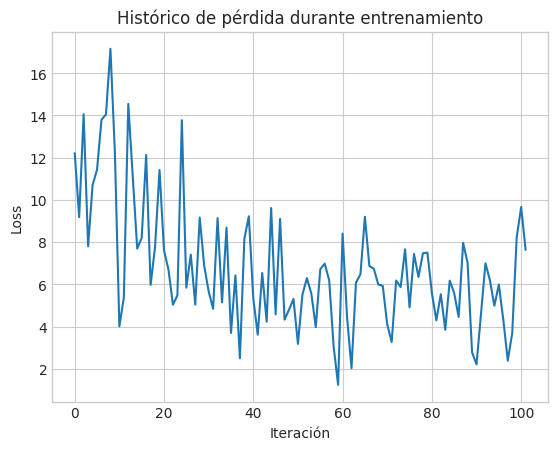

In [69]:
from src.train import plot_loss_curve

plot_loss_curve(loss_history)

In [70]:
# ----------------------------------------
# Predicción de ejemplo
# ----------------------------------------
model.eval()
with torch.no_grad():
    img, agent, gt = dataset_train[0]
    pred = model(img.unsqueeze(0), agent.unsqueeze(0))  # batch=1
    print("Predicción shape:", pred.shape)
    print("Primeros 10 valores del primer modo:\n", pred[0,:10])

Predicción shape: torch.Size([1, 25])
Primeros 10 valores del primer modo:
 tensor([-9.9507e-02,  3.8862e+00, -6.6820e-03,  6.7406e+00, -6.9206e-02,
         9.1518e+00, -1.4761e-01,  1.1831e+01, -7.8089e-02,  1.5006e+01],
       device='cuda:0')


### Data Integrity Check and NaN Handling

During the training of the first model, we realized there where nans in the data, so we validated the reliability of the input from out dataset because this was destabilizing the training process. 

During our initial tests, we discovered that some agents returned:
- undefined velocity,
- undefined acceleration,
- or undefined heading-change rate.

This typically happens when an agent has **just appeared in the scene**, and
there is not enough temporal history to estimate its motion. These missing
values propagate into the model and eventually create **exploding gradients or
NaN weights**, causing the training to fail.

To prevent this, we implemented a systematic NaN inspection and a correction
mechanism.

In [61]:
"""
We manually inspected several samples to check whether 
the rasterized image contains NaNs, the agent state vector conotains NaNs 
infinite or the ground-truth future trajectory is valid
"""
img, agent, gt = dataset_train[0]

print(f"Image - Max: {img.max()}, Min: {img.min()}, NaN?: {torch.isnan(img).any()}")
print(f"Agent - Max: {agent.max()}, Min: {agent.min()}, NaN?: {torch.isnan(agent).any()}")

if torch.isinf(agent).any():
    print("WARNING: Agent state contains infinities.")

Imagen - Max: 255.0, Min: 0.0, ¿Tiene NaN?: False
Agent - Max: 1.7065235376358032, Min: 0.0, ¿Tiene NaN?: False


A NaN in the input does not simply affect one prediction — it propagates through
the neural network, contaminating gradients and updating the model with invalid
values. Even a single NaN in a batch can:

- produce NaN losses,
- corrupt the backbone weights,
- break BatchNorm internal statistics,
- and stop the training entirely.

This is why catching NaNs early is essential.

In [58]:
img, agent, gt = dataset_train[0]
print("Ground Truth shape:", gt.shape)
print("First 10 values of GT:\n", gt[0,:10])    
print("Prediction shape:", pred.shape)
print("First 10 values of the first model:\n", pred[0,:10])

Ground Truth shape: torch.Size([1, 12, 2])
Primeros 10 valores de GT:
 tensor([[ 1.0751e-02,  2.4349e-01],
        [-2.0464e-01,  1.2052e+00],
        [-2.0399e-01,  2.5785e+00],
        [-2.5868e-01,  4.5031e+00],
        [-3.1359e-01,  6.6762e+00],
        [-3.1404e-01,  9.6773e+00],
        [-4.2374e-01,  1.2678e+01],
        [-4.2360e-01,  1.5844e+01],
        [-3.6769e-01,  1.8763e+01],
        [-2.6182e-02,  2.2007e+01]], device='cuda:0')
Predicción shape: torch.Size([1, 25])
Primeros 10 valores del primer modo:
 tensor([-0.3037, 12.0995, -1.5714, 24.9398, -0.5719, 36.4637,  0.2320, 45.9413,
         0.2748, 54.2586], device='cuda:0')


In [59]:
print("Weights first layer in backbone:")
print(list(model.parameters())[0])

# Check if any model parameter contains NaNs
hay_nans = False
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"ERROR! Layer '{name}' has NaNs.")
        hay_nans = True
        break

if not hay_nans:
    print("Model parameters are okay")

Pesos de la primera capa:
Parameter containing:
tensor([[[[-4.0558e-02, -9.3929e-03,  3.0640e-02,  ...,  1.3049e-02,
           -4.0353e-02,  1.6724e-02],
          [ 6.4763e-03, -1.4031e-02, -2.8611e-02,  ..., -1.2568e-02,
            5.8811e-03,  7.9615e-03],
          [-5.8900e-03,  4.0870e-02,  4.6862e-02,  ..., -1.9835e-02,
           -2.2262e-02,  5.3671e-03],
          ...,
          [-9.3316e-03, -2.8588e-02, -1.1897e-02,  ...,  3.8839e-02,
            4.9294e-03, -2.4093e-02],
          [-3.5811e-02,  8.9815e-03,  3.6416e-02,  ...,  3.4085e-02,
           -5.3101e-02, -3.4296e-02],
          [-1.6153e-04, -2.0168e-02, -7.1384e-03,  ..., -3.3246e-02,
            4.7837e-02,  3.5811e-02]],

         [[-1.9319e-02, -4.4821e-02, -4.2026e-03,  ...,  1.2618e-02,
            2.9825e-02,  4.8340e-02],
          [-2.4547e-03, -9.8648e-05, -1.1831e-02,  ...,  4.0798e-02,
           -1.7595e-02,  1.4343e-02],
          [ 4.0415e-02, -2.2234e-02, -2.6806e-02,  ..., -1.6615e-03,
          

In [60]:
# Verificamos los buffers (la memoria interna de BatchNorm)
for name, buf in model.named_buffers():
    if torch.isnan(buf).any():
        print(f"Layer '{name}' has NaNs.")
        break
else:
    print("Intern memory is okay.")

Revisando memoria interna (Buffers)...
✅ La memoria interna parece estar sana.


How to fix the problem: replace NaNs with 0: 

The source of the issue was that `PredictHelper` sometimes returns NaN velocity,
acceleration or heading-rate for agents that have too little motion history.

To fix this, we patched the dataset so that every agent state vector is cleaned
before being passed to the model:

```python
agent_state = torch.Tensor([vel, acc, hcr])
agent_state = torch.nan_to_num(agent_state, nan=0.0)

## Evaluation of the model

In [71]:
from src.dataset import NuScenesMTPInferenceDataset


In [73]:
def generate_submission_notebook(model, dataset, output_path="submission.json"):
    model.eval()
    predictions_list = []
    
    # Necesitamos el helper para buscar la pose del agente
    helper = dataset.helper 

    print(f"🚗 Generando submission con conversión LOCAL -> GLOBAL...")
    
    for i in tqdm(range(len(dataset))):
        img, agent_state, _, _ = dataset[i]
        
        # Recuperar tokens
        raw_token = dataset.split[i]
        instance_token, sample_token = raw_token.split("_")

        # Inferencia
        img = img.unsqueeze(0)        
        agent_state = agent_state.unsqueeze(0)
        with torch.no_grad():
            pred = model(img, agent_state)

        # Procesar salida (tu código de antes)
        total_output_size = pred.shape[1]
        num_modes = total_output_size // 25 
        num_coords = num_modes * 24
        
        pred_coords = pred[0, :num_coords]
        pred_probs = pred[0, num_coords:]
        
        # [Num_modos, 12, 2] en coordenadas LOCALES
        pred_coords_local = pred_coords.reshape(num_modes, 12, 2).cpu().numpy()

        # ============================================================
        # 🌍 TRANSFORMACIÓN CRÍTICA: LOCAL -> GLOBAL
        # ============================================================
        
        # 1. Obtener la pose actual del agente en el mapa global
        sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
        translation = sample_annotation['translation'] # [x, y, z] global
        rotation = sample_annotation['rotation']       # Quaternion global
        
        # 2. Convertir a matriz de transformación (Local -> Global)
        # Nota: transform_matrix espera rotación como Quaternion y translación
        # Pero ojo: MTP predice X,Y (2D). NuScenes es 3D.
        
        # Manera simplificada de rotar y trasladar vectores 2D:
        quaternion = Quaternion(rotation)
        
        # Creamos un array vacío para las coordenadas globales
        pred_coords_global = np.zeros_like(pred_coords_local)

        for mode_idx in range(num_modes):
            # Cogemos la trayectoria de un modo (Shape: 12, 2)
            trajectory_local = pred_coords_local[mode_idx]
            
            # A. Añadimos una columna de ceros para Z (necesario para rotación 3D)
            # Shape se convierte en (12, 3) -> [x, y, 0]
            traj_3d = np.hstack([trajectory_local, np.zeros((12, 1))])
            
            # B. Rotar (El agente mira hacia una dirección, rotamos los puntos)
            # Iteramos punto a punto o usamos vectorización si es posible. 
            # rotate funciona con vector único, así que iteramos para asegurar:
            traj_rotated = np.array([quaternion.rotate(p) for p in traj_3d])
            
            # C. Trasladar (Sumar la posición global actual del coche)
            # Solo sumamos X e Y (índices 0 y 1)
            pred_coords_global[mode_idx, :, 0] = traj_rotated[:, 0] + translation[0]
            pred_coords_global[mode_idx, :, 1] = traj_rotated[:, 1] + translation[1]
            
        # ============================================================

        # Probabilidades
        if num_modes > 1:
            probs = torch.nn.functional.softmax(pred_probs, dim=0).cpu().numpy()
        else:
            probs = np.array([1.0])

        prediction_obj = Prediction(
            instance=instance_token,
            sample=sample_token,
            prediction=pred_coords_global, # ¡USAMOS LAS GLOBALES!
            probabilities=probs
        )

        predictions_list.append(prediction_obj.serialize())

    with open(output_path, "w") as f:
        json.dump(predictions_list, f, indent=2)

    return output_path

The function `evaluate_submission` loads a submission file, runs the official
nuScenes evaluation pipeline, and stores the resulting metrics. Keeping this
code inside `src/` allows us to evaluate any trained model with a single
function call from our notebook.

In [74]:
from src.evaluate import evaluate_submission


In [75]:
mini_val = get_prediction_challenge_split("mini_val", dataroot=DATAROOT)
dataset_val = NuScenesMTPInferenceDataset(mini_val, helper, mtp_input_representation, device=device)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=4, shuffle=False)
len(mini_val)

61

In [ ]:
# Generar submission
submission_path = generate_submission_notebook(model, dataset_val, "submission_mtp.json")

🚗 Generando submission con conversión LOCAL -> GLOBAL...


100%|██████████| 61/61 [00:17<00:00,  3.55it/s]


In [111]:
# Evaluar
metrics = evaluate_submission("v1.0-mini", DATAROOT, submission_path)

📊 Cargando nuScenes y configuración de métricas...
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.236 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
📥 Cargando predicciones...
🏁 Calculando métricas...
📄 Métricas guardadas en submission_mtp_metrics.json

📌 Resultados:


defaultdict(dict,
            {'MinFDEK': {'RowMean': [59.79187436418312,
               59.79187436418312,
               59.79187436418312]},
             'MinADEK': {'RowMean': [35.7108615084484,
               35.7108615084484,
               35.7108615084484]},
             'MissRateTopK_2': {'RowMean': [1.0, 1.0, 1.0]},
             'OffRoadRate': {'RowMean': [1.0]}})

### Testing overfitting on a small subset of data

In [112]:
# Cogemos solo el primer batch y lo repetimos siempre
first_batch = next(iter(dataloader_train)) 
img, agent, gt = first_batch
# Mover a GPU
img, agent, gt = img.to(device), agent.to(device), gt.to(device)

In [114]:
print("🧠 Intentando memorizar un solo ejemplo...")
model.train()
for i in range(200): # 200 iteraciones sobre lo mismo
    optimizer.zero_grad()
    pred = model(img, agent)

    # Tu protección de NaN/Epsilon aquí
    gt_safe = gt.clone()
    gt_safe[:, :, -1, 0] += 1e-3 

    loss = loss_fn(pred, gt_safe)
    loss.backward()
    optimizer.step()

    if i % 20 == 0:
        print(f"Iter {i}: Loss = {loss.item():.6f}")

🧠 Intentando memorizar un solo ejemplo...
Iter 0: Loss = 5.029328
Iter 20: Loss = 0.693758
Iter 40: Loss = 0.119564
Iter 60: Loss = 0.025825
Iter 80: Loss = 0.014974
Iter 100: Loss = 0.008742
Iter 120: Loss = 0.003991
Iter 140: Loss = 0.008515
Iter 160: Loss = 0.001051
Iter 180: Loss = 0.000162


### Checking the issues with the data format and input representation

In [76]:
import numpy as np
import torch
from pyquaternion import Quaternion

# 1. Preparar datos (El mismo dato 0 que memorizamos)
idx = 0
dataset_target = dataset_train
img, agent_state, gt_local = dataset_target[idx]
raw_token = dataset_target.split[idx]
instance_token, sample_token = raw_token.split("_")

# 2. Obtener la Verdad Global (Directamente del Helper)
# Esto es lo que NuScenes espera recibir.
helper = dataset_target.helper
gt_global_real = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)

# 3. Obtener la Predicción Local del Modelo
model.eval()
with torch.no_grad():
    # Batch = 1
    pred = model(img.unsqueeze(0).to(device), agent_state.unsqueeze(0).to(device))

# Desempaquetar (Asumimos 1 modo por el tamaño 25, o el modo principal si hay 2)
# Nota: Si entrenaste con num_modes=2, la salida tiene tamaño 50.
# Vamos a coger el modo con mayor probabilidad o el primero.
total_output_size = pred.shape[1]
num_modes = total_output_size // 25
num_coords = num_modes * 24

pred_raw = pred[0, :num_coords]
# Reshape a [Modos, 12, 2]
pred_local_all = pred_raw.reshape(num_modes, 12, 2).cpu().numpy()

# Cogemos el primer modo para comparar (ya que overfiteamos, ambos deberían ser parecidos o uno dominante)
pred_local = pred_local_all[0]

# 4. Tu Transformación Manual (Local -> Global)
sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
translation = sample_annotation['translation']
rotation = sample_annotation['rotation']
quaternion = Quaternion(rotation)

# Tu lógica actual:
pred_global_calculated = np.zeros_like(pred_local)
traj_3d = np.hstack([pred_local, np.zeros((12, 1))]) # [x, y, 0]
traj_rotated = np.array([quaternion.rotate(p) for p in traj_3d])
pred_global_calculated[:, 0] = traj_rotated[:, 0] + translation[0]
pred_global_calculated[:, 1] = traj_rotated[:, 1] + translation[1]

# 5. 🖨️ EL MOMENTO DE LA VERDAD
print(f"--- DIAGNÓSTICO DE COORDENADAS PARA AGENTE {instance_token[:8]} ---")
print(f"Posición Actual del Agente (Translation): {translation[:2]}")
print(f"Rotación del Agente (Quaternion): {rotation}")
print("-" * 60)
print(f"{'Paso':<5} | {'Pred Local (Modelo)':<20} | {'GT Global (Real)':<25} | {'Pred Global (Tuya)':<25}")
print("-" * 60)

# Imprimimos solo el paso final (el más alejado, donde se ve mejor el error)
last_idx = -1 
print(f"FIN   | {pred_local[last_idx]}      | {gt_global_real[last_idx]}       | {pred_global_calculated[last_idx]}")

print("-" * 60)
# Calculamos el error en el último punto
error_dist = np.linalg.norm(gt_global_real[last_idx] - pred_global_calculated[last_idx])
print(f"🚨 ERROR FINAL (Distancia): {error_dist:.4f} metros")

# Análisis de vectores
vec_real = gt_global_real[last_idx] - translation[:2]
vec_calc = pred_global_calculated[last_idx] - translation[:2]
print(f"\nVector Movimiento REAL (desde origen): {vec_real}")
print(f"Vector Movimiento TUYO (desde origen): {vec_calc}")

# Verificar si es un problema de ejes intercambiados
print("\n--- HIPÓTESIS ---")
if np.abs(vec_real[0] - vec_calc[1]) < 5.0:
    print("⚠️ ¡Posible intercambio de ejes X/Y! (El modelo predice X pero lo pones en Y)")
elif np.linalg.norm(vec_real + vec_calc) < 5.0:
    print("⚠️ ¡Rotación Invertida! (El modelo predice adelante, tú lo pones atrás)")
else:
    print("⚠️ El ángulo de rotación parece incorrecto. Revisa el Quaternion.")

--- DIAGNÓSTICO DE COORDENADAS PARA AGENTE bc38961c ---
Posición Actual del Agente (Translation): [392.945, 1148.426]
Rotación del Agente (Quaternion): [-0.5443682117180475, 0.0, 0.0, 0.8388463804957943]
------------------------------------------------------------
Paso  | Pred Local (Modelo)  | GT Global (Real)          | Pred Global (Tuya)       
------------------------------------------------------------
FIN   | [ 0.42168772 34.844185  ]      | [ 380.066 1123.072]       | [ 424.59583 1133.8479 ]
------------------------------------------------------------
🚨 ERROR FINAL (Distancia): 45.8151 metros

Vector Movimiento REAL (desde origen): [-12.879 -25.354]
Vector Movimiento TUYO (desde origen): [ 31.6508252  -14.57809961]

--- HIPÓTESIS ---
⚠️ ¡Posible intercambio de ejes X/Y! (El modelo predice X pero lo pones en Y)


### Trainning and visualizing the results on the overfitting subset

In [78]:
# ==========================================
# 1. PREPARACIÓN DE DATOS (Manual, sin DataLoader)
# ==========================================
idx_target = 0  # Elegimos el índice 0 para que sea estable
dataset_target = dataset_train

# Extraemos los datos manualmente
img_raw, agent_raw, gt_raw = dataset_target[idx_target]
raw_token = dataset_target.split[idx_target]
instance_token, sample_token = raw_token.split("_")

# Creamos el batch manual (unsqueeze) y movemos a GPU
img = img_raw.unsqueeze(0).to(device)
agent = agent_raw.unsqueeze(0).to(device)
gt = gt_raw.unsqueeze(0).to(device)

print(f"🎯 Objetivo: Memorizar el agente {instance_token} en la muestra {sample_token}")

# ==========================================
# 2. ENTRENAMIENTO DE OVERFITTING
# ==========================================


# 1. Creamos el backbone de nuevo (por defecto nace en CPU)
backbone_cpu = ResNetBackbone('resnet50') 

# 2. Creamos el modelo MTP (La prueba interna se hará CPU con CPU -> OK)
model = MTP(backbone_cpu, num_modes=2)

# 3. AHORA SÍ: Movemos todo el conjunto a la GPU
model = model.to(device)

# 4. Definimos el optimizador (siempre después de mover el modelo a GPU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = MTPLoss(num_modes=2, regression_loss_weight=1., angle_threshold_degrees=5.)

print("✅ Modelo reinicializado y movido a GPU correctamente.")

print("\n🧠 Memorizando...")
model.train()
for i in range(150): # 150 iteraciones bastan si es el mismo dato
    optimizer.zero_grad()
    pred = model(img, agent)

    # Truco epsilon
    gt_safe = gt.clone()
    gt_safe[:, :, -1, 0] += 1e-3 

    loss = loss_fn(pred, gt_safe)
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"   Iter {i}: Loss = {loss.item():.6f}")

print(f"   Iter FINAL: Loss = {loss.item():.6f} (¡Memorizado!)")

# ==========================================
# 3. INFERENCIA Y TRANSFORMACIÓN (CÓDIGO UNIFICADO)
# ==========================================
print("\n🌍 Transformando predicción...")
model.eval()
with torch.no_grad():
    pred = model(img, agent)

# Desempaquetar salida del modelo
total_output_size = pred.shape[1]
num_modes = total_output_size // 25 
num_coords = num_modes * 24
pred_coords = pred[0, :num_coords]
pred_probs = pred[0, num_coords:]

# Reshape a [Modos, 12 pasos, 2 coordenadas]
pred_coords_local = pred_coords.reshape(num_modes, 12, 2).cpu().numpy()

# Preparar transformación Global
helper = dataset_target.helper 
sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
translation = sample_annotation['translation']
rotation = sample_annotation['rotation']
quaternion = Quaternion(rotation)

# Array vacío para guardar el resultado global
pred_coords_global = np.zeros_like(pred_coords_local)

# --- BUCLE DE TRANSFORMACIÓN CON EL FIX ---
for mode_idx in range(num_modes):
    # 1. Cogemos la trayectoria local de este modo
    trajectory_local = pred_coords_local[mode_idx]
    
    # 2. Preparamos el contenedor 3D
    traj_3d = np.zeros((12, 3))

    # 3. 🔥 EL INTERCAMBIO MÁGICO (SWAP X/Y) 🔥
    # El modelo MTP aprende que Y es "Adelante".
    # La rotación espera que X sea "Adelante".
    
    # Mapeamos Y del modelo --> a X de rotación
    traj_3d[:, 0] = trajectory_local[:, 1] 
    
    # Mapeamos X del modelo --> a Y de rotación (invertido por regla mano derecha)
    traj_3d[:, 1] = -trajectory_local[:, 0]
    
    # 4. Rotamos y Trasladamos
    traj_rotated = np.array([quaternion.rotate(p) for p in traj_3d])
    
    pred_coords_global[mode_idx, :, 0] = traj_rotated[:, 0] + translation[0]
    pred_coords_global[mode_idx, :, 1] = traj_rotated[:, 1] + translation[1]

# ==========================================
# 4. GUARDAR Y EVALUAR
# ==========================================
output_path = "submission_overfit_FIXED.json"

if num_modes > 1:
    probs = torch.nn.functional.softmax(pred_probs, dim=0).cpu().numpy()
else:
    probs = np.array([1.0])

prediction_obj = Prediction(
    instance=instance_token,
    sample=sample_token,
    prediction=pred_coords_global,
    probabilities=probs
)

with open(output_path, "w") as f:
    json.dump([prediction_obj.serialize()], f, indent=2)

print(f"\n📊 Evaluando {output_path}...")
# Asegúrate de usar 'dataroot' (en minúsculas) o 'DATAROOT' según tengas definido
metrics = evaluate_submission_notebook("v1.0-mini", DATAROOT, output_path)

print("\n--- VEREDICTO FINAL ---")
print(f"MinFDE (Debería ser < 2m): {metrics['MinFDEK']['RowMean'][0]:.4f} m")

🎯 Objetivo: Memorizar el agente bc38961ca0ac4b14ab90e547ba79fbb6 en la muestra 39586f9d59004284a7114a68825e8eec
✅ Modelo reinicializado y movido a GPU correctamente.

🧠 Memorizando...
   Iter 0: Loss = 6.610729
   Iter 50: Loss = 0.021980
   Iter 100: Loss = 0.000105
   Iter FINAL: Loss = 0.000001 (¡Memorizado!)

🌍 Transformando predicción...

📊 Evaluando submission_overfit_FIXED.json...
📊 Cargando nuScenes y configuración de métricas...
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.221 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.
📥 Cargando predicciones...
🏁 Calculando métricas...
📄 Métricas guardadas en submission_overfit_FIXED_metrics.json

📌 Resultados:


defaultdict(dict,
            {'MinFDEK': {'RowMean': [0.2772397763852107,
               0.2772397763852107,
               0.2772397763852107]},
             'MinADEK': {'RowMean': [0.12001473209246045,
               0.12001473209246045,
               0.12001473209246045]},
             'MissRateTopK_2': {'RowMean': [0.0, 0.0, 0.0]},
             'OffRoadRate': {'RowMean': [0.5]}})


--- VEREDICTO FINAL ---
MinFDE (Debería ser < 2m): 0.2772 m


## Visualitzation of the results

In [85]:
# --- FUNCIONES AUXILIARES ---
def meters_to_pixels(coords_meters, img_size=500, resolution=0.2, center_offset=(250, 250)):
    """
    Convierte coordenadas locales (metros) a coordenadas de imagen (píxeles).
    Asume que el agente está en el centro de la imagen mirando hacia ARRIBA.
    
    Coords input: [Lateral (X), Adelante (Y)] según descubrimos en tu modelo.
    """
    # Desempaquetamos
    lateral_meters = coords_meters[:, 0]
    forward_meters = coords_meters[:, 1]
    
    center_x, center_y = center_offset
    
    # Conversión a píxeles
    # X en imagen aumenta hacia la derecha. Lateral positivo es derecha.
    pix_x = center_x + (lateral_meters / resolution)
    
    # Y en imagen aumenta hacia ABAJO. Forward positivo es ARRIBA (restamos).
    pix_y = center_y - (forward_meters / resolution)
    
    return pix_x, pix_y

In [86]:
# 1. Usamos los tokens y datos del caso de Overfitting
# (Asegúrate de que estas variables instance_token y sample_token siguen definidas de la celda anterior)
print(f"Visualizando Agente: {instance_token} en Sample: {sample_token}")

# 2. Obtener la IMAGEN BASE (Rasterizada)
# Usamos el código que tú propusiste
img_raster = mtp_input_representation.make_input_representation(instance_token, sample_token)

# 3. Obtener REALIDAD LOCAL (Ground Truth en metros, desde el helper)
gt_local_meters = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=True)

# 4. Obtener PREDICCIÓN LOCAL (Del modelo overfiteado)
# Recuperamos los datos crudos del dataset para inferencia
img_tensor, agent_tensor, _ = dataset_train[idx] # Usamos el mismo idx=0 del overfitting

model.eval()
with torch.no_grad():
    # Inferencia
    pred_raw = model(img_tensor.unsqueeze(0).to(device), agent_tensor.unsqueeze(0).to(device))

# Desempaquetar (Asumimos 1 modo principal ya que está overfiteado)
num_modes = pred_raw.shape[1] // 25
pred_coords_all = pred_raw[0, :num_modes*24].reshape(num_modes, 12, 2).cpu().numpy()
pred_local_meters = pred_coords_all[0] # Tomamos el primer modo

# 5. CONVERTIR A PÍXELES
# Importante: el rasterizador estándar suele usar resolución 0.2m/px (100m en 500px)
gt_pix_x, gt_pix_y = meters_to_pixels(gt_local_meters, resolution=0.2)
pred_pix_x, pred_pix_y = meters_to_pixels(pred_local_meters, resolution=0.2)

print("Datos preparados. Listos para visualizar.")

Visualizando Agente: bc38961ca0ac4b14ab90e547ba79fbb6 en Sample: 39586f9d59004284a7114a68825e8eec
Datos preparados. Listos para visualizar.


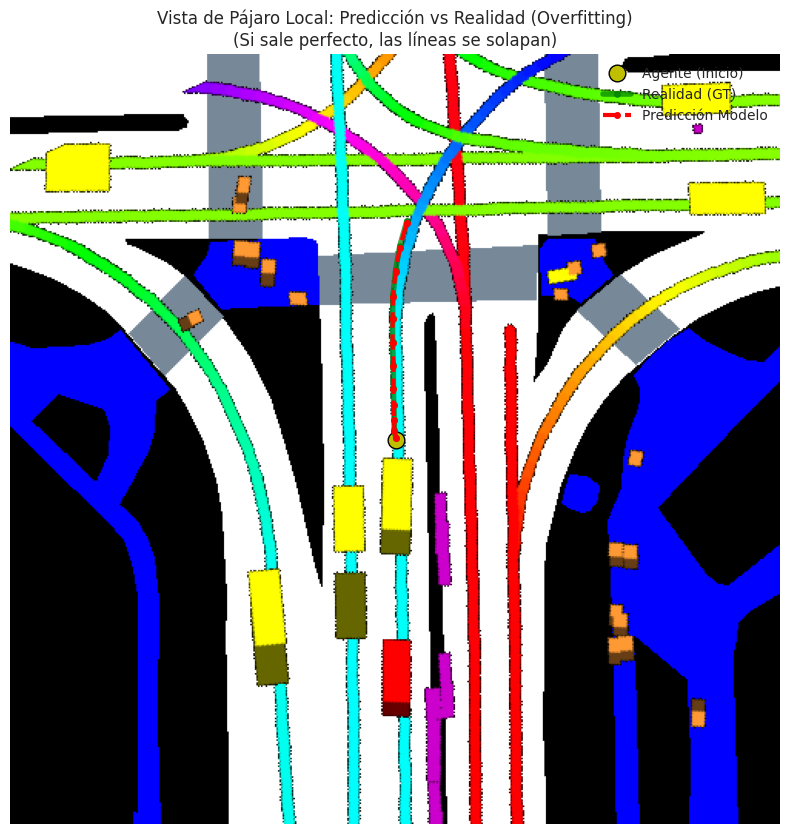

In [87]:
plt.figure(figsize=(10, 10))

# 1. Mostrar la imagen rasterizada de fondo
plt.imshow(img_raster)

# 2. Pintar el Agente (punto central)
plt.plot(250, 250, 'yo', markersize=12, markeredgecolor='k', label='Agente (Inicio)')

# 3. Pintar Realidad (Verde grueso)
plt.plot(gt_pix_x, gt_pix_y, 'g.-', linewidth=4, markersize=8, alpha=0.7, label='Realidad (GT)')

# 4. Pintar Predicción (Rojo discontinuo encima)
plt.plot(pred_pix_x, pred_pix_y, 'r.--', linewidth=3, markersize=8, label='Predicción Modelo')

plt.legend()
plt.title("Vista de Pájaro Local: Predicción vs Realidad (Overfitting)\n(Si sale perfecto, las líneas se solapan)")
plt.axis('off')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_raster)
ax.axis('off')
ax.set_title("Animación Local: Predicción (Rojo) vs Realidad (Verde)")

# Inicializar elementos vacíos
line_gt, = ax.plot([], [], 'g-', linewidth=3, alpha=0.6, label='Traza Real')
point_gt, = ax.plot([], [], 'go', markersize=10, label='Posición Real')

line_pred, = ax.plot([], [], 'r--', linewidth=2, label='Traza Predicción')
point_pred, = ax.plot([], [], 'ro', markersize=10, label='Posición Predicha')

ax.legend(loc='upper left')

def init():
    line_gt.set_data([], [])
    point_gt.set_data([], [])
    line_pred.set_data([], [])
    point_pred.set_data([], [])
    return line_gt, point_gt, line_pred, point_pred

def update(frame):
    # Frame va de 0 a 11 (los 12 pasos)
    
    # Actualizar Realidad
    line_gt.set_data(gt_pix_x[:frame+1], gt_pix_y[:frame+1])
    point_gt.set_data([gt_pix_x[frame]], [gt_pix_y[frame]])
    
    # Actualizar Predicción
    line_pred.set_data(pred_pix_x[:frame+1], pred_pix_y[:frame+1])
    point_pred.set_data([pred_pix_x[frame]], [pred_pix_y[frame]])
    
    return line_gt, point_gt, line_pred, point_pred

# Crear animación (interval=300ms para que vaya lento y se vea bien)
anim = FuncAnimation(fig, update, frames=len(gt_pix_x), init_func=init, blit=True, interval=300)

plt.close() # Cierra la figura estática para no duplicar
HTML(anim.to_jshtml())

## Example of predictions of the given models

In [32]:
# Output has 50 entries.
# The first 24 are x,y coordinates (in the agent frame) over the next 6 seconds at 2 Hz for the first mode.
# The second 24 are the x,y coordinates for the second mode.
# The last 2 are the logits of the mode probabilities
mtp(image_tensor, agent_state_vector)

tensor([[-0.4722,  0.0940,  0.0944, -0.3452, -0.3831, -0.1014, -0.2964,  0.2138,
          0.2087, -0.1032, -0.0693,  0.0484, -0.3192, -0.2811,  0.4033,  0.0573,
          0.0506,  0.1549, -0.2726, -0.0401, -0.0248,  0.2477,  0.0996,  0.2361,
          0.0736, -0.1809, -0.1061,  0.1989, -0.3852, -0.0794, -0.2422,  0.2265,
          0.0710,  0.1583, -0.3074,  0.3842,  0.0627,  0.3958,  0.1914,  0.0223,
         -0.0086, -0.2465, -0.2904,  0.0301, -0.1012,  0.0910, -0.0481,  0.5211,
         -0.1293,  0.2014]], grad_fn=<CatBackward0>)

In [33]:
# CoverNet outputs a probability distribution over the trajectory set.
# These are the logits of the probabilities
logits = covernet(image_tensor, agent_state_vector)
print(logits)

tensor([[0.2051, 0.0000, 0.0000, 0.0067, 0.1162, 0.1489, 0.4808, 0.0000, 0.0054,
         0.2889, 0.1636, 0.0000, 0.0000, 0.5061, 0.0000, 0.0000, 0.1298, 0.2001,
         0.0000, 0.2733, 0.0787, 0.0000, 0.0000, 0.0000, 0.2774, 0.2099, 0.0000,
         0.1813, 0.0000, 0.0910, 0.2978, 0.0000, 0.1731, 0.2611, 0.0466, 0.2091,
         0.0809, 0.1843, 0.1020, 0.3017, 0.0424, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4504, 0.0000, 0.0000, 0.0000, 0.2066, 0.0996, 0.2359, 0.0000, 0.0497,
         0.0474, 0.3462, 0.0228, 0.0000, 0.0000, 0.0000, 0.0000, 0.0299, 0.0000,
         0.1498]], grad_fn=<ReluBackward0>)


The CoverNet model outputs a probability distribution over a set of trajectories. To be able to interpret the predictions, and perform inference with CoverNet, you need to download the trajectory sets from the nuscenes website. Download them from this [link](https://www.nuscenes.org/public/nuscenes-prediction-challenge-trajectory-sets.zip) and unzip them in a directory of your choice.

Uncomment the following code when you do so:

In [ ]:
# Epsilon is the amount of coverage in the set, 
# i.e. a real world trajectory is at most 8 meters from a trajectory in this set
# We released the set for epsilon = 2, 4, 8. Consult the paper for more information
# on how this set was created

PATH_TO_EPSILON_8_SET = "/root/nuscenes-devkit/data/sets/nuscenes/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl"
trajectories = pickle.load(open(PATH_TO_EPSILON_8_SET, 'rb'))

# Saved them as a list of lists
trajectories = torch.Tensor(trajectories)

# Print 5 most likely predictions
trajectories[logits.argsort(descending=True)[:5]]

tensor([[[[-3.1574e-02,  1.1319e+00],
          [-1.2441e-01,  2.2596e+00],
          [-2.7815e-01,  3.3813e+00],
          ...,
          [-8.6814e+00,  1.1549e+01],
          [-1.0839e+01,  1.2414e+01],
          [-1.3083e+01,  1.3017e+01]],

         [[ 1.2200e-01,  1.2458e+00],
          [ 1.8237e-01,  2.0071e+00],
          [ 4.8923e-01,  3.7707e+00],
          ...,
          [ 9.0014e+00,  1.5289e+01],
          [ 1.1476e+01,  1.6198e+01],
          [ 1.3959e+01,  1.7067e+01]],

         [[ 7.7594e-03,  3.9072e-01],
          [ 1.2776e-01,  1.0276e+00],
          [ 2.7158e-01,  1.7191e+00],
          ...,
          [ 9.1397e+00,  4.3757e+00],
          [ 1.0203e+01,  2.7667e+00],
          [ 1.1100e+01,  5.0248e-01]],

         ...,

         [[ 2.8032e-05, -3.6125e-02],
          [-1.2867e-04,  5.8796e-02],
          [ 3.2033e-02,  5.6407e-01],
          ...,
          [-1.9501e-01,  2.6561e+01],
          [-3.2043e-01,  3.2369e+01],
          [-4.5230e-01,  3.8565e+01]],

     

We also provide two physics-based models - A constant velocity and heading model and a physics oracle. The physics oracle estimates the future trajectory of the agent with several physics based models and chooses the one that is closest to the ground truth. It represents the best performance a purely physics based model could achieve on the dataset.

In [ ]:
cv_model = ConstantVelocityHeading(sec_from_now=6, helper=helper)
physics_oracle = PhysicsOracle(sec_from_now=6, helper=helper)

The physics models can be called as functions. They take as input a string of the instance and sample token of the agent concatenated with an underscore ("_").

The output is a `Prediction` data type. The `Prediction` data type stores the predicted trajectories and their associated probabilities for the agent. We'll go over the `Prediction` type in greater detail in the next section.

In [37]:
cv_model(f"{instance_token_img}_{sample_token_img}")

Prediction(instance=bc38961ca0ac4b14ab90e547ba79fbb6, sample=7626dde27d604ac28a0240bdd54eba7a, prediction=[[[ 388.17909232 1136.96919062]
  [ 387.06818463 1134.47838124]
  [ 385.95727695 1131.98757186]
  [ 384.84636926 1129.49676248]
  [ 383.73546158 1127.0059531 ]
  [ 382.6245539  1124.51514372]
  [ 381.51364621 1122.02433435]
  [ 380.40273853 1119.53352497]
  [ 379.29183084 1117.04271559]
  [ 378.18092316 1114.55190621]
  [ 377.07001548 1112.06109683]
  [ 375.95910779 1109.57028745]]], probabilities=[1])

In [ ]:
physics_oracle(f"{instance_token_img}_{sample_token_img}")

Prediction(instance=bc38961ca0ac4b14ab90e547ba79fbb6, sample=7626dde27d604ac28a0240bdd54eba7a, prediction=[[[ 388.17909232 1136.96919062]
  [ 387.06818463 1134.47838124]
  [ 385.95727695 1131.98757186]
  [ 384.84636926 1129.49676248]
  [ 383.73546158 1127.0059531 ]
  [ 382.6245539  1124.51514372]
  [ 381.51364621 1122.02433435]
  [ 380.40273853 1119.53352497]
  [ 379.29183084 1117.04271559]
  [ 378.18092316 1114.55190621]
  [ 377.07001548 1112.06109683]
  [ 375.95910779 1109.57028745]]], probabilities=[1])

## 6. Making a submission to the challenge

Participants must submit a zipped json file containing serialized `Predictions` for each agent in the validation set.

The previous section introduced the `Prediction` data type. In this section, we explain the format in greater detail. 

A `Prediction` consists of four fields:

1. instance: The instance token for the agent.
2. sample: The sample token for the agent.
3. prediction: Prediction from model. A prediction can consist of up to 25 proposed trajectories. This field must be a numpy array with three dimensions (number of trajectories (also called modes), number of timesteps, 2).
4. probabilities: The probability corresponding to each predicted mode. This is a numpy array with shape `(number_of_modes,)`.

You will get an error if any of these conditions are violated.

In [ ]:
# 1. Cargar el Dataset (Mini)
DATAROOT = '/root/nuscenes-devkit/data/sets/nuscenes'
nusc = NuScenes('v1.0-mini', dataroot=DATAROOT, verbose=False)
helper = PredictHelper(nusc)

# 2. Elegir un Agente y Momento de prueba
# Usamos el token que sale en el tutorial como ejemplo
instance_token_img = 'bc38961ca0ac4b14ab90e547ba79fbb6'
sample_token_img = '7626dde27d604ac28a0240bdd54eba7a'

# 3. Obtener el Ground Truth (La realidad futura: 6 segundos, 2Hz = 12 puntos)
future_xy_local = helper.get_future_for_agent(
    instance_token_img, sample_token_img, seconds=6, in_agent_frame=False
)

# 4. Crear una "Predicción" (Simulada)
# CORRECCIÓN: 'instance' y 'sample' deben ser STRINGS (los tokens reales), no números.
# Aquí simulamos que tu modelo predijo una línea recta (un poco desviada de la realidad)
prediccion_simulada = future_xy_local + 1.5  # Añadimos 1.5m de error artificial
prediccion_simulada = np.expand_dims(prediccion_simulada, 0) # Forma: (1 modo, 12 pasos, 2 coord)

mi_prediccion = Prediction(
    instance=instance_token_img,     # <--- STRING CORRECTO
    sample=sample_token_img,         # <--- STRING CORRECTO
    prediction=prediccion_simulada,  # Array numpy (n_modos, tiempo, 2)
    probabilities=np.array([1.0])    # Probabilidad del modo
)

print("✅ Objeto Predicción creado correctamente.")

# 5. Calcular las Métricas (La "Nota" del modelo)
# Definimos las métricas que queremos usar (K=1 porque solo tenemos 1 modo)
metrica_ade = MinADEK(k_to_report=[1], aggregators=[RowMean()])
metrica_fde = MinFDEK(k_to_report=[1], aggregators=[RowMean()])

# Calculamos el error comparando con el Ground Truth
valor_ade = metrica_ade(future_xy_local, mi_prediccion)
valor_fde = metrica_fde(future_xy_local, mi_prediccion)

print("\n--- RESULTADOS DE LA EVALUACIÓN ---")
print(f"📉 MinADE_1 (Error Promedio): {valor_ade[0][0]:.4f} metros")
print(f"🏁 MinFDE_1 (Error Final):    {valor_fde[0][0]:.4f} metros")

✅ Objeto Predicción creado correctamente.

--- RESULTADOS DE LA EVALUACIÓN ---
📉 MinADE_1 (Error Promedio): 2.1213 metros
🏁 MinFDE_1 (Error Final):    2.1213 metros


In [43]:
# This would raise an error because instance is not a string.

Prediction(instance=instance_token_img, sample=sample_token_img,
          prediction=np.ones((1, 12, 2)), probabilities=np.array([1]))

Prediction(instance=bc38961ca0ac4b14ab90e547ba79fbb6, sample=7626dde27d604ac28a0240bdd54eba7a, prediction=[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]], probabilities=[1])